In [18]:
import os
import itertools
import seaborn as sns
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [26]:
sns.set_theme()
np.random.seed(0)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
# sns.set(style="whitegrid")
sns.set_style("whitegrid")
# Load results
sns.set(font_scale=1.7)
sns.set_style("darkgrid")

fig_dir = '../half_seminar/figs'
def read_json(path):
    validation = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip().replace("'", '"')
            line = line.replace("nan", '"nan"')
            try:
                data = json.loads(line)
            except:
                print(line)
                raise
            if data['_meta']['type'] == 'validation':
                validation.append(data)
    return validation


def transform(entry, atk, agg, m, s, d, b, bz):
    if "large" in atk:
        atk_name = r"IPM ($\epsilon = 100$)"
    elif atk == "IPM":
        atk_name = r"IPM ($\epsilon = 0.5$)"
    else:
        atk_name = atk

    if b == 0:
        atk_name = "No Attack"

    return {
        'Round Number': entry['E'],
        'Accuracy (%)': entry['top1'],
        'Loss': entry['Loss'],
        'ATK': atk_name,
        "Batch Size": bz,
        'Setting': d.replace('f', 'F', 1),
        'AGG': fedavg_methods[agg]['name'],
        r"$\beta$": m,
        'seed': s,
        r"$M$": b,
        r"$\delta=0$": False,
    }


b = 8

attacks = ["Noise", "BF", "LF", "IPM", 'IPM_large', "ALIE"]
aggs = ["avg", "krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']
aggs = ["krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']

fedavg_methods = {
    'avg': {'name': 'Mean', 'marker': '^'},
    'rfa': {'name': 'GeoMed', 'marker': 's'},
    'autogm': {'name': 'AutoGM', 'marker': 's'},
    'krum': {'name': 'Krum', 'marker': '|'},
    'cp': {'name': 'CC', 'marker': 'p'},
    'cm': {'name': 'Median', 'marker': 'D'},
    'tm': {'name': 'TrimmedMean', 'marker': '8'},
    'clustering': {'name': 'Clustering', 'marker': 'o'},
    'clippedclustering': {'name': 'ClippedClustering', 'marker': 'v'}
}

col_order = [fedavg_methods[k]['name'] for k in aggs]


def append_loop_path(bs, seeds, attacks, aggs, ms, dir_name, data_collection, ROOT_PATH, bzs=None):
    if not bzs:
        bzs = [32]
    for bz in bzs:
        for b in bs:
            for seed in seeds:
                for attack in attacks:
                    for agg in aggs:
                        for m in ms:
                            try:
                                batch_size = '_bz' + str(bz) if bz != 32 else ""
                                path = ROOT_PATH.format(d=dir_name, f=b, atk=attack, agg=agg, m=m, b=b, bz=batch_size,
                                                        s=seed)
                                data_collection[path] = read_json(path)
                                if len(data_collection[path]) < 150:
                                    print(path)
                            except Exception as e:
                                print(e)
                                raise
    return data_collection


def append_loop_df(bs, seeds, attacks, aggs, ms, dir_name, df, ROOT_PATH, data_collection, bzs=None):
    if not bzs:
        bzs = [32]
    for bz in bzs:
        for b in bs:
            for seed in seeds:
                for attack in attacks:
                    for agg in aggs:
                        for m in ms:
                            try:
                                batch_size = '_bz' + str(bz) if bz != 32 else ""
                                path = ROOT_PATH.format(d=dir_name, f=b, atk=attack, agg=agg, m=m, b=b, bz=batch_size,
                                                        s=seed)
                                validation_entries = data_collection[path]
                                df += list(map(lambda x: transform(x, atk=attack, agg=agg, m=m, s=seed, d=dir_name, b=b,
                                                                   bz=bz), validation_entries))
                            except Exception as e:
                                print("Error", e)
                                raise
    return df


def plot_all(dir_name, num_round=7500):
    ROOT_PATH = "../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}_seed{s}/stats"  #% (dir_name)
    data_collection = {}
    
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attacks, aggs=aggs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH)

    data_collection = append_loop_path(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=aggs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH)

    df = []
    df = append_loop_df(bs=[8], seeds=[0], attacks=attacks, aggs=aggs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df = pd.DataFrame(df)
    
    df_noattack = []
    df_noattack = append_loop_df(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=aggs,
                                 ms=[0.0], dir_name=dir_name, df=df_noattack, ROOT_PATH=ROOT_PATH,
                                 data_collection=data_collection)
    df_noattack = pd.DataFrame(df_noattack)

    data = pd.concat([df_noattack, df], ignore_index=True)
    
    data.loc[(data["Setting"] == "Fedsgd_iid") | (data["Setting"] == "Fedsgd_noniid"), "Round Number"] *= 50
    data["Communication Rounds"] = data["Round Number"]
    g = sns.relplot(
        data=data,
        x="Communication Rounds", y="Accuracy (%)",
        col="AGG",
        #     row=r"$\beta$",
        hue="ATK",
        #     style=r"$\delta=0$",
        height=4.5, aspect=1.25,
        col_order=col_order,
        markers=True,
        col_wrap=4,
        
        linewidth=3.0,
        kind="line"
    )
    #     g.set(xlim=(0, num_round))

    sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.05), ncol=8, title=None, frameon=False)

    g.savefig(os.path.join(fig_dir, dir_name + ".pdf"), bbox_inches="tight")

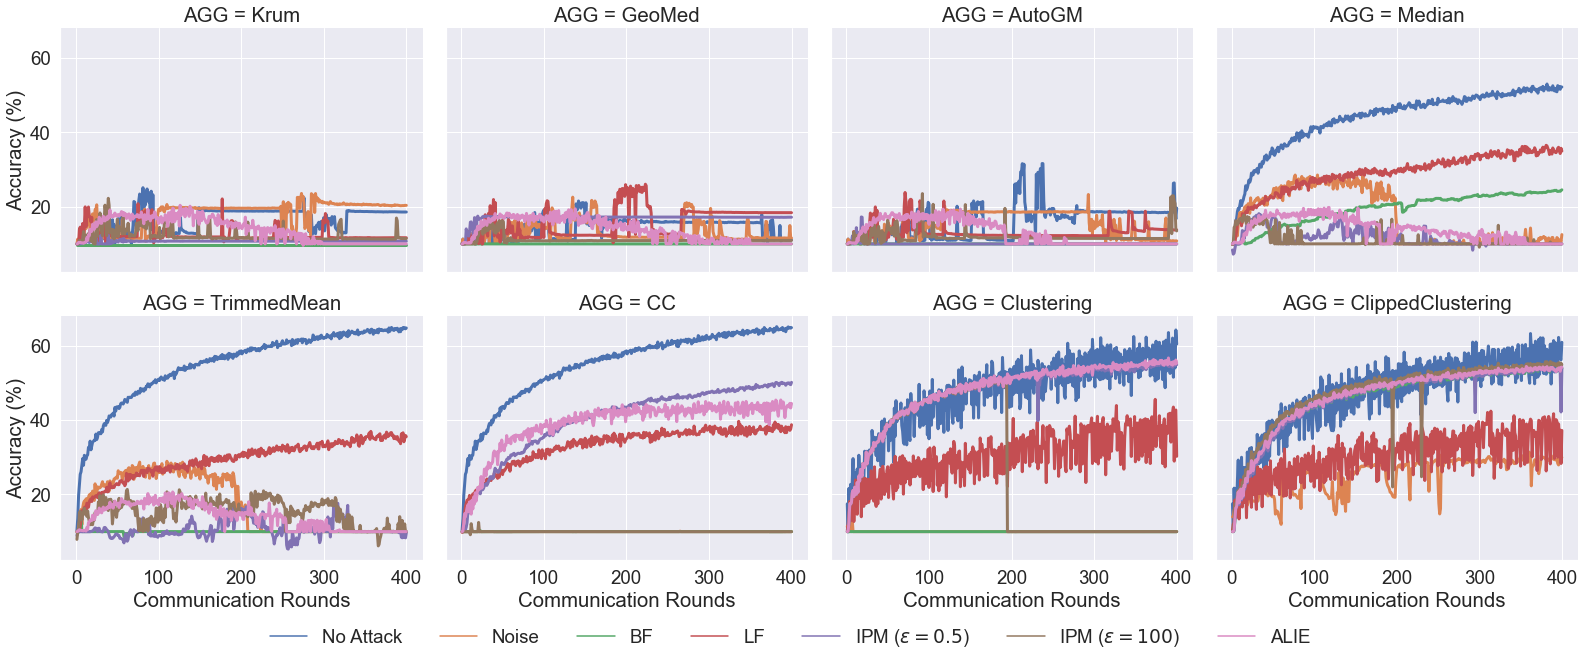

In [20]:
plot_all("fedavg_noniid", 400)

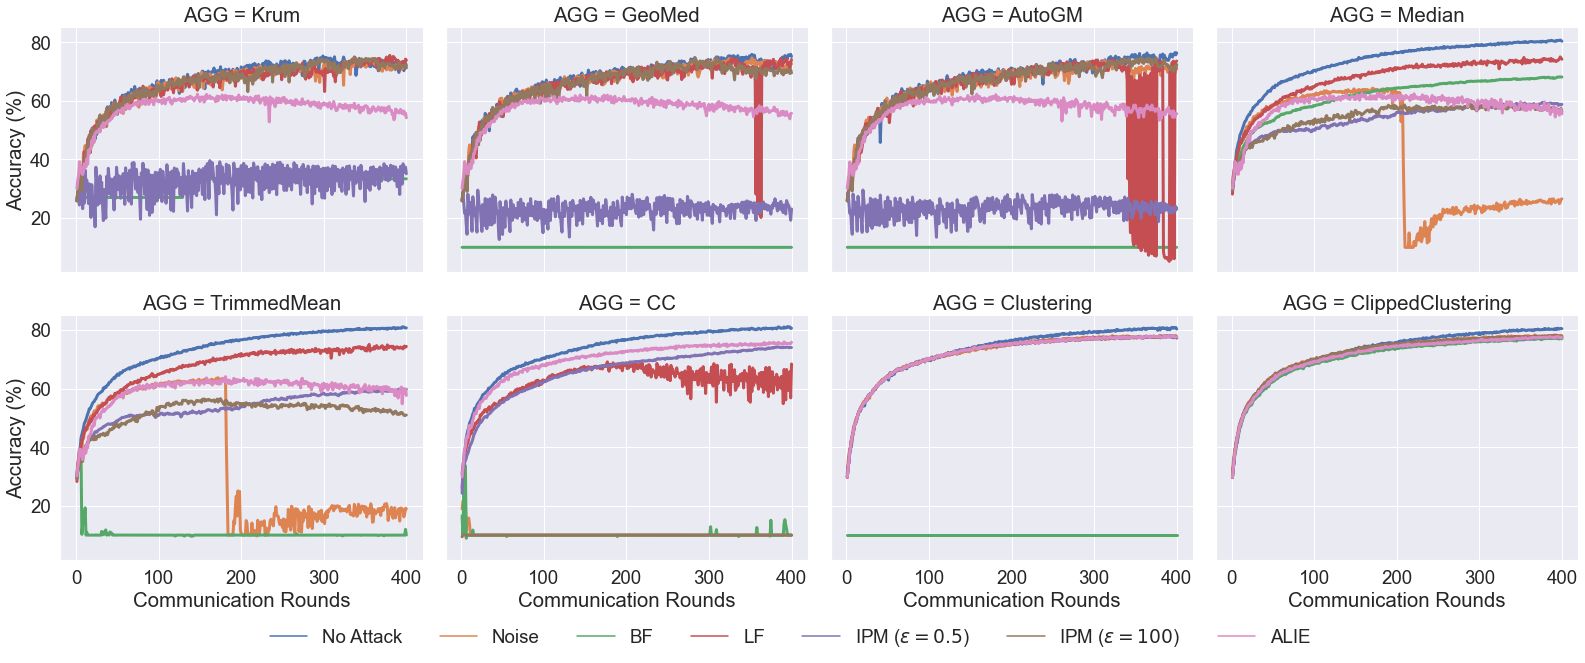

In [21]:
plot_all("fedavg_iid", 400)

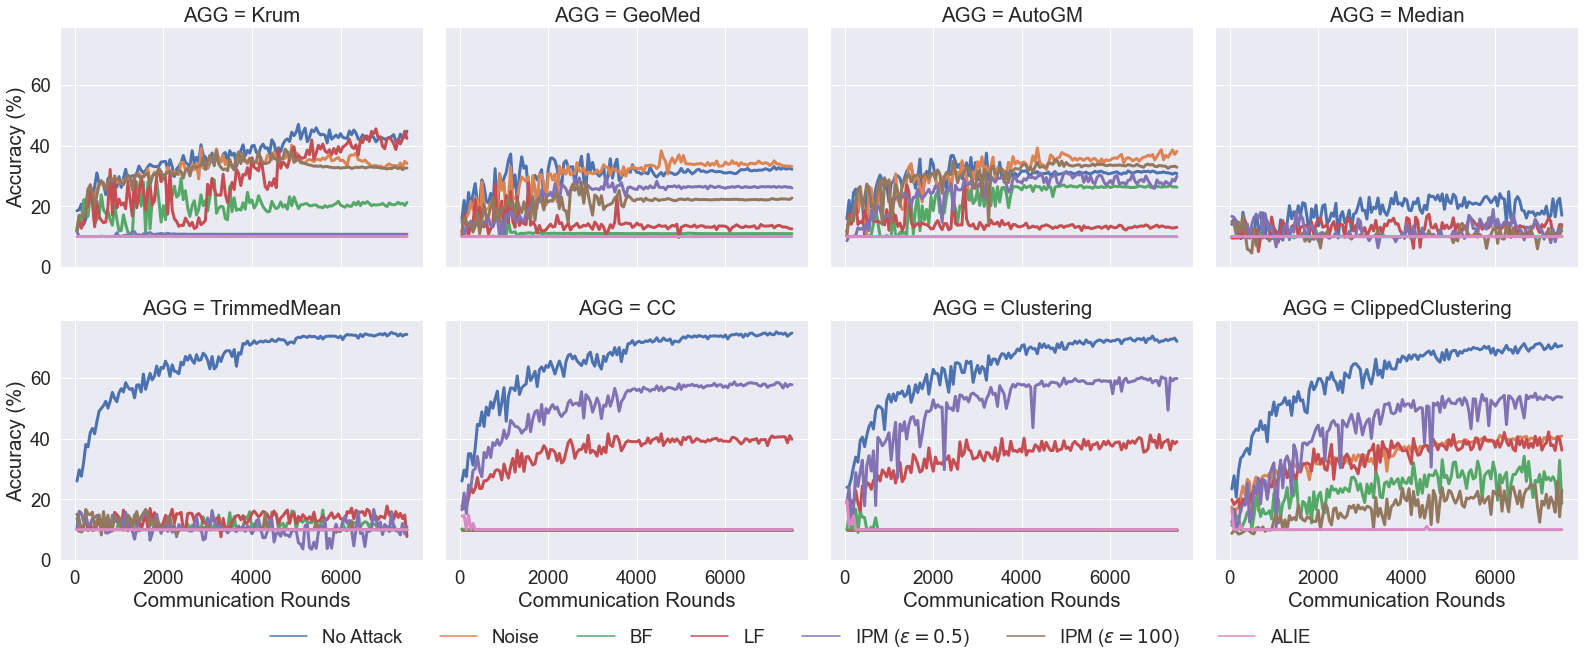

In [22]:
plot_all("fedsgd_noniid", 7500)

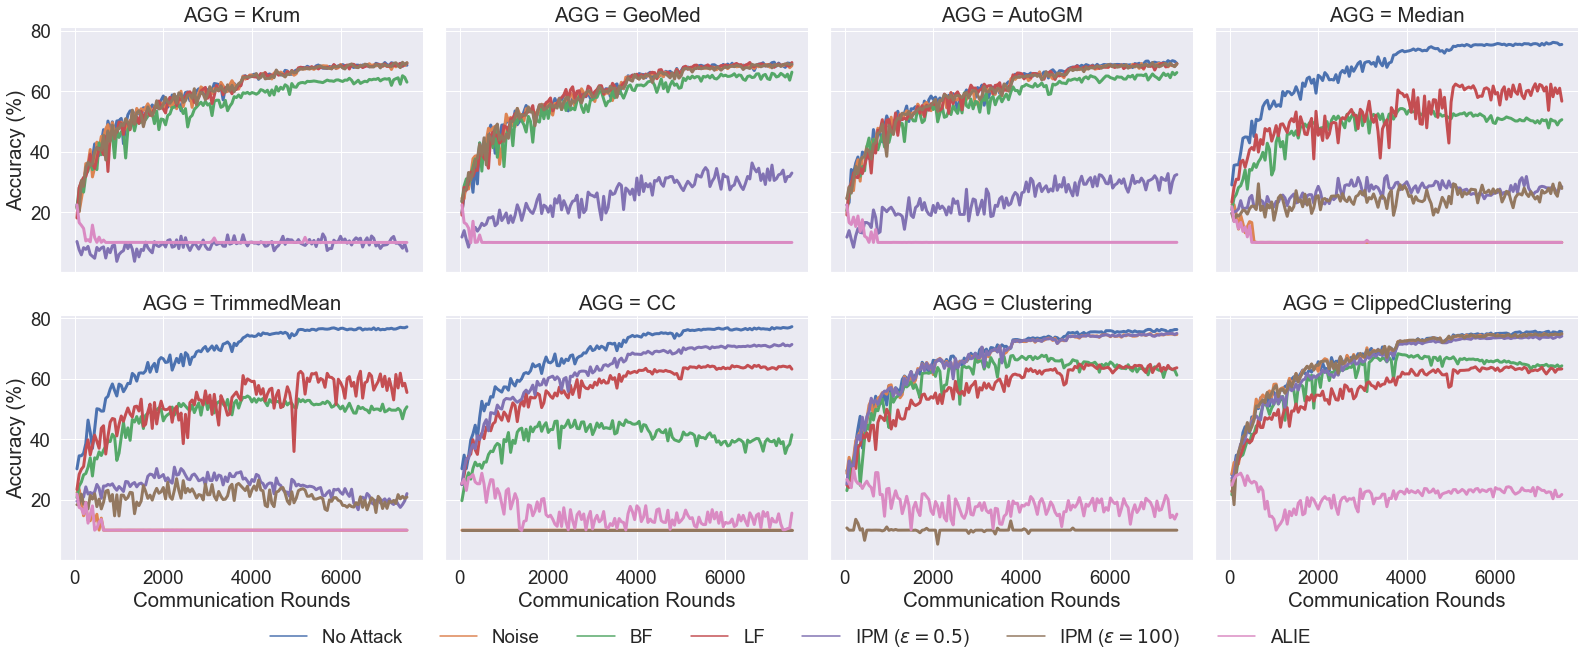

In [23]:
plot_all("fedsgd_iid", 7500)

In [30]:
data_collection = {}
df = []
avgs = ['avg']
ROOT_PATH = "../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}_seed{s}/stats"
for dir_name in ['fedsgd_iid', 'fedsgd_noniid', 'fedavg_iid', 'fedavg_noniid']:
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attacks, aggs=avgs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH)
    data_collection = append_loop_path(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=avgs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH)
    
    df = append_loop_df(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=avgs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df = append_loop_df(bs=[8], seeds=[0], attacks=attacks, aggs=avgs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)

df = pd.DataFrame(df)
data = pd.DataFrame(df)
data.loc[(data["Setting"] == "Fedsgd_iid") | (data["Setting"] == "Fedsgd_noniid"), "Round Number"] *= 50
data["Communication Rounds"] = data["Round Number"]

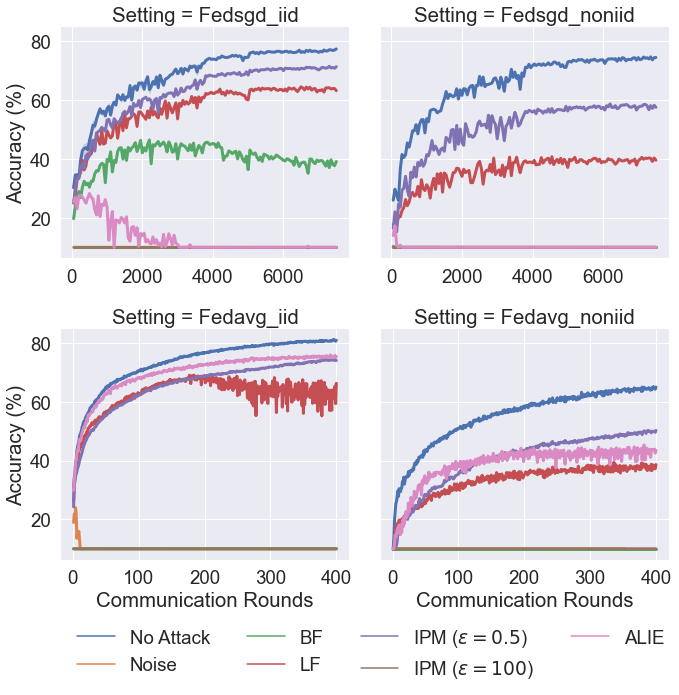

In [31]:
g = sns.relplot(
    data=data, x="Communication Rounds", y="Accuracy (%)", col="Setting", hue="ATK",
    facet_kws={'sharey': True, 'sharex': False}, height=4.5, aspect=1.1, markers=True,
    col_wrap=2, linewidth=3.0, kind="line"
)

sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.1), ncol=4, title=None, frameon=False)

g.savefig("avg.pdf", bbox_inches="tight")

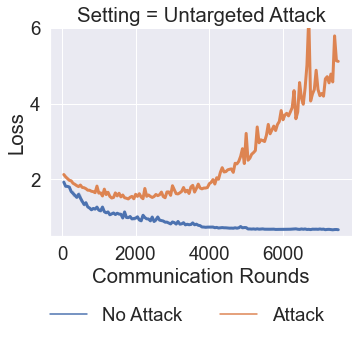

In [51]:
# data['Loss'] = data['Loss'].fillna(10000)
attacks = ["BF"]
data_collection = {}
df = []
avgs = ['avg']
ROOT_PATH = "../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}_seed{s}/stats"
for dir_name in ['fedsgd_iid']:
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attacks, aggs=avgs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH)
    data_collection = append_loop_path(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=avgs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH)

    df = append_loop_df(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=avgs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df = append_loop_df(bs=[8], seeds=[0], attacks=attacks, aggs=avgs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)

df = pd.DataFrame(df)
data = pd.DataFrame(df)
data.loc[(data["Setting"] == "Fedsgd_iid") | (data["Setting"] == "Fedsgd_noniid"), "Round Number"] *= 50
data["Communication Rounds"] = data["Round Number"]

data['Loss'] = pd.to_numeric(data['Loss'], errors='coerce').fillna(10000)
data['Setting'] = 'Untargeted Attack'
data.replace('BF', 'Attack', inplace=True)
g = sns.relplot(
    data=data, x="Communication Rounds", y="Loss", col="Setting", hue="ATK",
    facet_kws={'sharey': True, 'sharex': False}, height=4.5, aspect=1.1, markers=True,
    col_wrap=2, linewidth=3.0, kind="line"
)

g.set(ylim=(0.5, 6.0))
sns.move_legend(g, "lower center", bbox_to_anchor=(.25, -0.1), ncol=4, title=None, frameon=False)

g.savefig(os.path.join(fig_dir,"attack.pdf"), bbox_inches="tight")

In [9]:
data_collection = {}
df = []
bzs = [32, 128, 512, 2500]
attack = ["ALIE"]
ROOT_PATH = "../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}{bz}_seed{s}/stats"
# aggs += ["avg"]
for dir_name in ['fedsgd_iid']:
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attack, aggs=["avg"] + aggs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH, bzs=bzs)
    
    df = append_loop_df(bs=[8], seeds=[0], attacks=attack, aggs=["avg"] + aggs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection,
                        bzs=bzs)

data = pd.DataFrame(df)
data["Communication Rounds"] = data["Round Number"] * 50

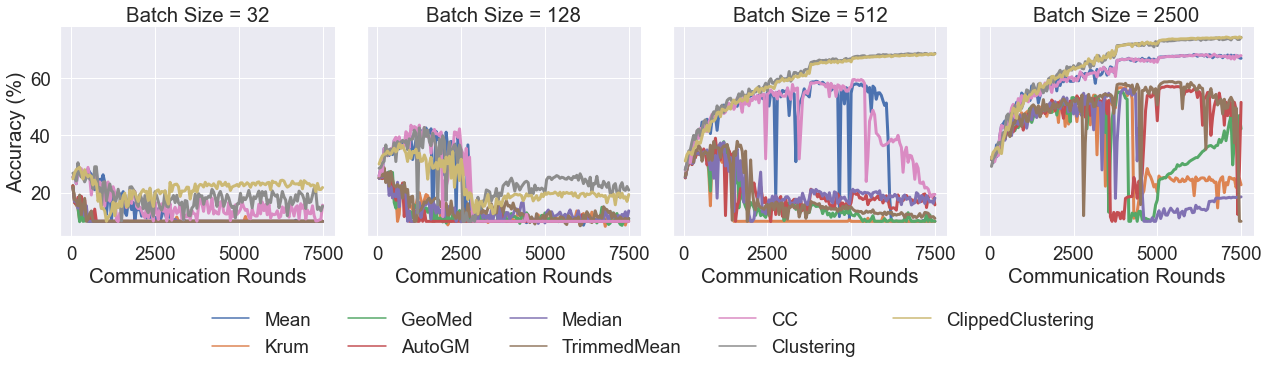

In [10]:
g = sns.relplot(
    data=data,
    x="Communication Rounds", y="Accuracy (%)",
    col="Batch Size",
    hue="AGG",
    facet_kws={'sharey': True, 'sharex': False},
    height=4.5, aspect=1,
    markers=True,
    col_wrap=4,
    linewidth=3.0,
    kind="line"
)

sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.2), ncol=5, title=None, frameon=False)

g.savefig("batch_size.pdf", bbox_inches="tight")

In [11]:
data_collection = {}
df = []
bzs = [32]
bs = [2, 4, 6, 8]
attack = ["BF"]
ROOT_PATH = "../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}{bz}_seed{s}/stats"
# aggs += ["avg"]
for dir_name in ['fedavg_iid']:
    data_collection = append_loop_path(bs=bs, seeds=[0], attacks=attack, aggs=["avg"] + aggs,
                                       ms=[0.0], dir_name=dir_name, data_collection=data_collection,
                                       ROOT_PATH=ROOT_PATH, bzs=bzs)
    
    df = append_loop_df(bs=bs, seeds=[0], attacks=attack, aggs=["avg"] + aggs,
                        ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection,
                        bzs=bzs)

data = pd.DataFrame(df)
data["Communication Rounds"] = data["Round Number"]

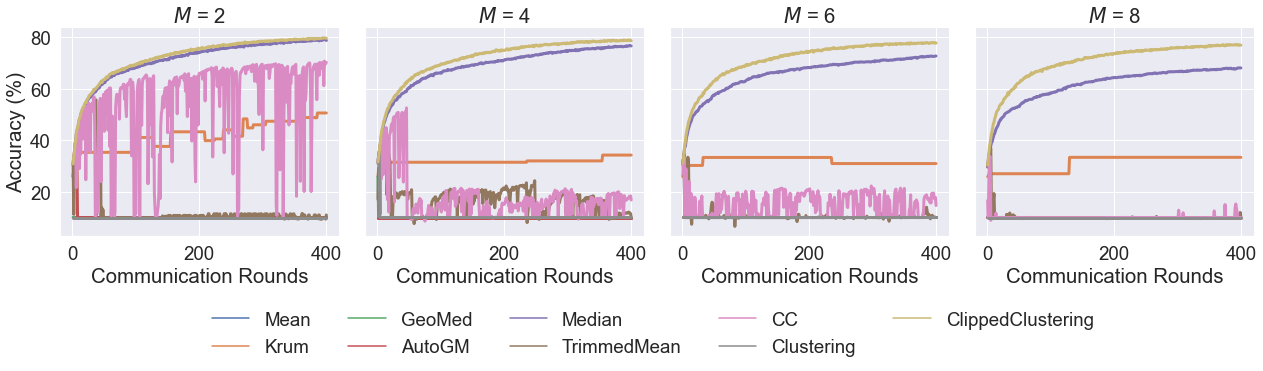

In [12]:
g = sns.relplot(
    data=data,
    x="Communication Rounds", y="Accuracy (%)",
    col=r"$M$",
    hue="AGG",
    facet_kws={'sharey': True, 'sharex': False},
    height=4.5, aspect=1,
    markers=True,
    col_wrap=4,
    linewidth=3.0,
    kind="line"
)

sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.2), ncol=5, title=None, frameon=False)

g.savefig("num_byzantine.pdf", bbox_inches="tight")

/Users/sheli564/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


TypeError: Got both 'fontsize' and 'size', which are aliases of one another

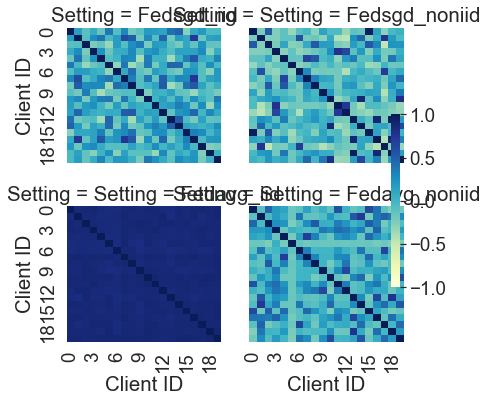

In [13]:
sim_sgd_noniid = np.load('updates_fedsgd_noniid.npy')
sim_avg_noniid = np.load('updates_fedavg_noniid.npy')
sim_sgd_iid = np.load('updates_fedsgd_iid.npy')
sim_avg_iid = np.load('updates_fedavg_iid.npy')
data = [("Setting = Fedsgd_iid", i, j, sim_sgd_iid[i, j]) for i in range(len(sim_avg_iid)) for j in
        range(len(sim_avg_iid))]
data.extend([("Setting = Fedsgd_noniid", i, j, sim_sgd_noniid[i, j])
             for i in range(len(sim_avg_noniid))
             for j in range(len(sim_avg_noniid))])
data.extend([("Setting = Fedavg_iid", i, j, sim_avg_iid[i, j])
             for i in range(len(sim_avg_iid))
             for j in range(len(sim_avg_noniid))])
data.extend([("Setting = Fedavg_noniid", i, j, sim_avg_noniid[i, j])
             for i in range(len(sim_avg_noniid))
             for j in range(len(sim_avg_noniid))])
df = pd.DataFrame(data, columns=["Setting", 'i', 'j', 'value'])

methods = ['method 1', 'method2', 'method 3', 'method 4']
times = range(0, 100, 10)
data = pd.DataFrame(list(itertools.product(methods, times, times)))
data.columns = ['method', 'dtsi', 'rtsi']
data['nw_score'] = np.random.sample(data.shape[0])


def facet_heatmap(data, color, **kws):
    data = data.pivot(index="i", columns='j', values='value')
    s = sns.heatmap(data, cmap='YlGnBu', center=0, **kws)  # <-- Pass kwargs to heatmap
    s.set(xlabel='Client ID', ylabel='Client ID')


with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(df, col="Setting", col_wrap=2, height=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=-1, vmax=1)  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
g.fig.subplots_adjust(right=.9)
g.savefig("similarity.pdf", bbox_inches="tight")

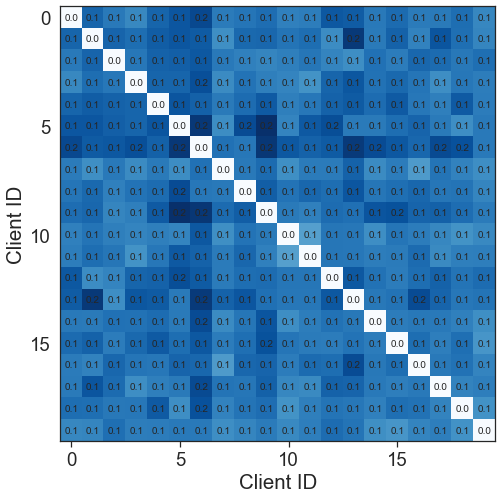

In [14]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 8))

intersection_matrix = 1 - sim_avg_iid

ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

for i in range(intersection_matrix.shape[0]):
    for j in range(intersection_matrix.shape[0]):
        c = np.around(intersection_matrix[j, i], 1)
        ax.text(i, j, str(c), va='center', ha='center', fontsize=10)

# ax.set_xticklabels(range(sim_avg_iid.shape[0]), fontsize=10)  
# ax.set_yticklabels('')
ax.set_ylabel('Client ID')
ax.set_xlabel('Client ID')
ax.xaxis.set_ticks_position('bottom')
plt.savefig("cosine.pdf", bbox_inches="tight")

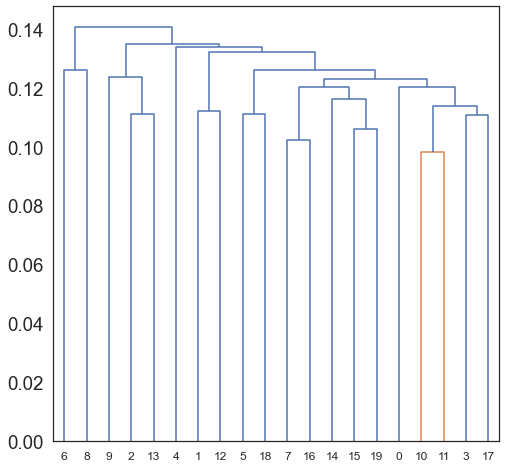

In [15]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity='precomputed', compute_distances=True, linkage='average', n_clusters=2)
model.fit(intersection_matrix)
fig, ax = plt.subplots(figsize=(8, 8))
plot_dendrogram(model, truncate_mode="level", p=10)
plt.savefig("shc.pdf", bbox_inches="tight")
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()